# Number density and bias with real data

In [16]:
import os, sys
import esutil
import healpy as hp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.append('../code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color_elg, assignELGProb, doVisualization_1d, XD_fitting_X
from run_DMASS_Y3 import priorCut_test
#from systematics import *

# Loading Catalogs

Lading Y3 Gold catalog

In [31]:
#loading y3 gold catalogs
input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/5ad2a08f172445728b475911782f76f2/'
input_keyword = 'Y3_GOLD'
columns = \
['RA', 'DEC', 'HPIX_4096', 
'COADD_OBJECT_ID', 
'EBV_SFD98',
'SOF_CM_MAG_CORRECTED_G',
'SOF_CM_MAG_CORRECTED_R',
'SOF_CM_MAG_CORRECTED_I',
'SOF_CM_MAG_CORRECTED_Z',
'SOF_CM_MAG_ERR_G',
'SOF_CM_MAG_ERR_R',
'SOF_CM_MAG_ERR_I',
'SOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
mask_magcut = priorCut_test(gold_st82)
#gold_st82 = gold_st82[mask_magcut]


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000002.fits
Y3_GOLD_2_0_STRIPE82_000003.fits
Y3_GOLD_2_0_STRIPE82_000004.fits
Y3_GOLD_2_0_STRIPE82_000005.fits
Y3_GOLD_2_0_STRIPE82_000006.fits
Y3_GOLD_2_0_STRIPE82_000007.fits
Y3_GOLD_2_0_STRIPE82_000008.fits
Y3_GOLD_2_0_STRIPE82_000009.fits
Y3_GOLD_2_0_STRIPE82_000010.fits
Y3_GOLD_2_0_STRIPE82_000011.fits
Y3_GOLD_2_0_STRIPE82_000012.fits
Y3_GOLD_2_0_STRIPE82_000013.fits
Y3_GOLD_2_0_STRIPE82_000014.fits
Y3_GOLD_2_0_STRIPE82_000015.fits
Y3_GOLD_2_0_STRIPE82_000016.fits
Y3_GOLD_2_0_STRIPE82_000017.fits
Y3_GOLD_2_0_STRIPE82_000018.fits
Y3_GOLD_2_0_STRIPE82_000019.fits
Y3_GOLD_2_0_STRIPE82_000020.fits
Y3_GOLD_2_0_STRIPE82_000021.fits
Y3_GOLD_2_0_STRIPE82_000022.fits
Y3_GOLD_2_0_STRIPE82_000023.fits
Y3_GOLD_2_0_STRIPE82_000024.fits
Y3_GOLD_2_0_STRIPE82_000025.fits
Y3_GOLD_2_0_STRIPE82_000026.fits
Y3_GOLD_2_0_STRIPE82_000027.fits
Y3_GOLD_2_0_STRIPE82_000028.fits
Y3_GOLD_2_0_STRIPE82_000029.fits
Y3_GOLD_2_0_STRIPE82_

Loading LOWZ sample

In [5]:
filename = '/n/des/lee.5922/data/lowz_cat/galaxy_DR12v5_LOWZ_South.fits.gz'
#filename = '/n/des/lee.5922/data/eboss_cat/eBOSS_ELG_full_ALLdata-vDR16.fits'
#filename = '/n/des/lee.5922/data/eboss_cat/eBOSS_ELG_clustering_data-SGC-vDR16.fits'
lowz = esutil.io.read(filename)

# Add healpix index to LOWZ catalog
healConfig = {'map_inside':4096,
              'out_nside':4096,
              'nest':False}
lowz = HealPixifyCatalogs(catalog=lowz, healConfig=healConfig, ratag='RA', dectag = 'DEC')

Calling Y3 GOLD footprint map 

In [7]:
# calling Y3 GOLD footprint map
# downloaded from https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Y3A2_Gold_footprint
mapname='../data/masks/y3a2_footprint_griz_1exp_v2.0.fits.gz'
hpmap_y3gold = hp.read_map(mapname)
goodmask = hp.mask_good(hpmap_y3gold)
hpind_y3gold = np.arange(hpmap_y3gold.size)

# Generate mask for eboss ELG
mask_train = np.in1d(lowz['HEALIndex'],hpind_y3gold[goodmask])

# Apply mask to extract eBOSS ELG in the Y3 gold region
# This results 76722 CMASS galaxies
train_sample = lowz[mask_train]

/n/des/lee.5922/programs/anaconda3/envs/env_py3/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [8]:
# convert hp indices to ra/dec and split into st82 (training) and spt (test) regions. 
# Apply a rough cut (DEC > -10.0)
ra_hpmap_y3gold, dec_hpmap_y3gold = hpHEALPixelToRaDec( hpind_y3gold[goodmask], nside = 4096, nest=False )
mask_hpmap_y3gold_training = dec_hpmap_y3gold > -10.0
mask_hpmap_y3gold_testing = dec_hpmap_y3gold < -10.0

pixarea = hp.nside2pixarea( 4096, degrees = True)
npix_training =  np.sum(mask_hpmap_y3gold_training)
npix_testing = np.sum(mask_hpmap_y3gold_testing)
TrainingMapArea = pixarea * npix_training
TestingMapArea = pixarea * npix_testing
print ('<Survey Area> \n-This is a rough estimation')
print ('training region (dec > -10.0):{:5.0f} sq.deg'.format(TrainingMapArea) )
print ('testing region  (dec < -10.0):{:5.0f} sq.deg'.format(TestingMapArea) )

<Survey Area> 
-This is a rough estimation
training region (dec > -10.0):  818 sq.deg
testing region  (dec < -10.0): 4245 sq.deg


In [32]:
# matching GOLD and lowz galaxies positions to find the lowz couterparts in GOLD
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                     gold_st82['DEC'],2./3600, maxmatch=1)
clean_lowz_data_sdss = train_sample[mg1]
clean_lowz_data_des = gold_st82[mg2]
lowz_mask = np.zeros(gold_st82.size, dtype=bool)
lowz_mask[mg2] = 1
#clean_lowz_data_des = gold_st82[lowz_mask]
nolowz = gold_st82[~lowz_mask]

In [10]:
# save training samples
outdir = '../output/test_lowz/train_cat/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'train_sample_des.fits', clean_lowz_data_des, clobber=True)
esutil.io.write( outdir+'train_sample_sdss.fits', clean_lowz_data_sdss, clobber=True)

In [13]:
# Draw a random sample from the training sample to reduce the sample size for a fast run
# Put sample size you want 
n_sample =  int(clean_lowz_data_des.size)  # train cmass sample size
n_sample_non = int(nolowz.size/50)          # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_lowz_data_des.size), size = n_sample)
clean_lowz_data_des_sub = clean_lowz_data_des[sampling_ind]
print('num of randomly sampled lowz ', clean_lowz_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nolowz.size), size = n_sample_non )
nolowz_sub = nolowz[random_sampling_ind]
print('num of randomly sampled non-lowz ', nolowz_sub.size)
lowz_fraction = clean_lowz_data_des.size *1./gold_st82.size
print('lowz_fraction (lowz/non-lowz): ', lowz_fraction)

# save the fraction of lowz galaxies in the training sample
# This number will be called and used when assigning the lowz probability to GOLD galaxies. 
outdir = '../output/test_lowz/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'lowzfrac', 'w')
f.write('{:0.10f}'.format(lowz_fraction))
f.close()

random sampling... 
num of randomly sampled lowz  8841
num of randomly sampled non-lowz  56095
lowz_fraction (lowz/non-lowz):  0.003142212016322016


In [14]:
gold_st82=None

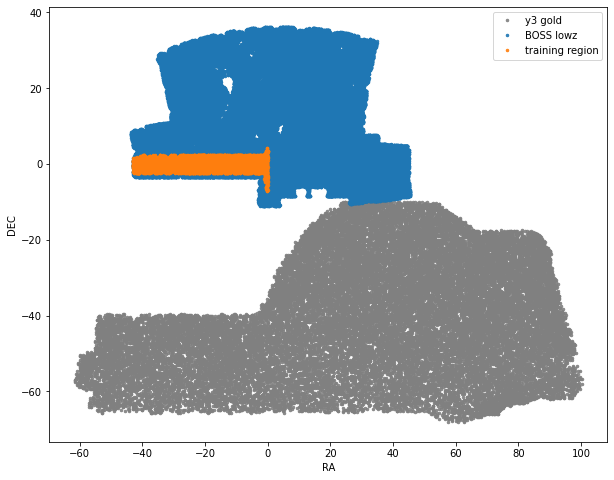

In [19]:
# Plotting footprint
#y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam10_000001.fits')
y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam100.fits')
randind=np.random.choice(y3goldsam.size, size=10000 )
spatialcheck([y3goldsam, lowz, clean_lowz_data_des], 
             label = ['y3 gold', 'BOSS lowz', 'training region'], 
             convert = None, ratag='RA',dectag='DEC')

In [22]:
from xd import mixing_color

In [29]:
# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_lowz_true, X_lowz_cov = mixing_color_elg(clean_lowz_data_des, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True)

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color_elg(nolowz_sub, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True)

Using central 98% to set range.


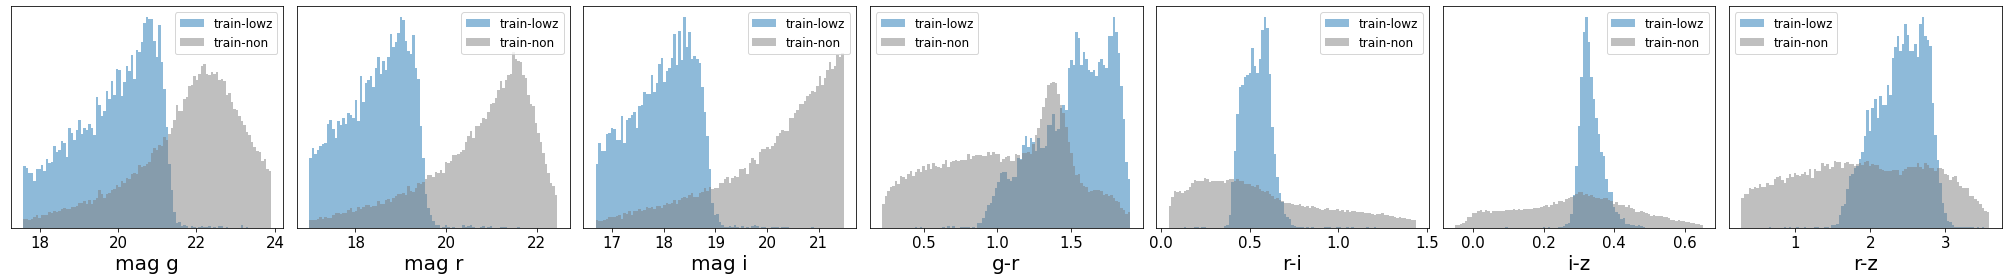

In [30]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
filename = 'figure/hist_color_lowz.png'
doVisualization_1d(data=[X_lowz_true, X_no_true], 
                   labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   ranges = None, 
                   name = ['train-lowz', 'train-non'], 
                   color= ['tab:blue', 'grey'],
                   weight = [None,None], 
                   nbins=100, filename=filename)

# Extreme Deconvolution Fitting

In [22]:
# number of gaussian mixtures
n_elg = None    # for fitting the cmass distributions
n_no = None       # for fitting the non-cmass distributions

# number of XD iteration. 
# I set this number small for a fast run but 
# should be run until the XD algorithm converges
n_iter_elg = 10
n_iter_no = 1
# tolerance
tol = 1E-5

# pickle filename
outdir = '../output/test_elg/fitting/'
os.makedirs(outdir, exist_ok=True)
elg_pickle = outdir+'gm_elg_Mgri_Cgr_rz.pkl'.format(n_elg)
no_pickle = outdir+'gm_no_Mgri_Cgr_rz.pkl'.format(n_no)

In [163]:
# XD Fitting. This will take a while 

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I', 'Z']

clf_elg = XD_fitting_X( X = X_elg_true, Xcov = X_elg_cov, pickleFileName = elg_pickle, 
                       mag=mag, err=err, filter=filter, 
                       n_cl = n_elg, n_iter = n_iter_elg, tol = tol, 
                       verbose = True, init_params= None)                 
clf_no = XD_fitting_X( X = X_no_true, Xcov = X_no_cov, pickleFileName = no_pickle, 
                    mag=mag, err=err, filter=filter, 
                    n_cl = n_no, n_iter = n_iter_no, tol = tol, 
                    verbose = True, init_params = None)

@pickle_results: computing results and saving to '../output/test_elg/fitting/gm_elg_Mgri_Cgr_rz.pkl'
    - args match:   False
    - kwargs match: True
@pickle_results: using precomputed results from '../output/test_elg/fitting/gm_elg_Mgri_Cgr_rz.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  16
n components = 16
tolerance = 1e-05


/n/des/lee.5922/programs/anaconda3/envs/env_py3/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


1: log(L) = 113294.7295
    (13 sec)
2: log(L) = 113638.0516
    (13 sec)
3: log(L) = 113848.157
    (13 sec)
4: log(L) = 114002.8545
    (13 sec)
5: log(L) = 114126.7413
    (13 sec)
6: log(L) = 114230.649
    (13 sec)
7: log(L) = 114320.0481
    (13 sec)
8: log(L) = 114398.1014
    (13 sec)
9: log(L) = 114467.1859
    (13 sec)
10: log(L) = 114529.0447
    (13 sec)
elapsed time: 1.94 min,  total iteration 9                                 
@pickle_results: computing results and saving to '../output/test_elg/fitting/gm_no_Mgri_Cgr_rz.pkl'
@pickle_results: computing results and saving to '../output/test_elg/fitting/gm_no_Mgri_Cgr_rz.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  46


/n/des/lee.5922/programs/anaconda3/envs/env_py3/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


n components = 46
tolerance = 1e-05
1: log(L) = 101921.8137
    (1.1e+02 sec)
elapsed time: 0.00 min,  total iteration 0                                 


In [14]:
# callig saved pickles 
#clf_cmass = XD_fitting( None, pickleFileName = cmass_pickle)               
#clf_no = XD_fitting( None, pickleFileName = no_pickle)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [164]:
# Drawing random samples from the fitted Gaussian mixture model
# If the model is correct, the random sample should match with the training sample
X_sample_elg = clf_elg.sample(10000)  # cmass model
X_sample_no = clf_no.sample(10000)        # non-cmass model

In [166]:
X_elg_true.shape

(35235, 5)

Using central 98% to set range.


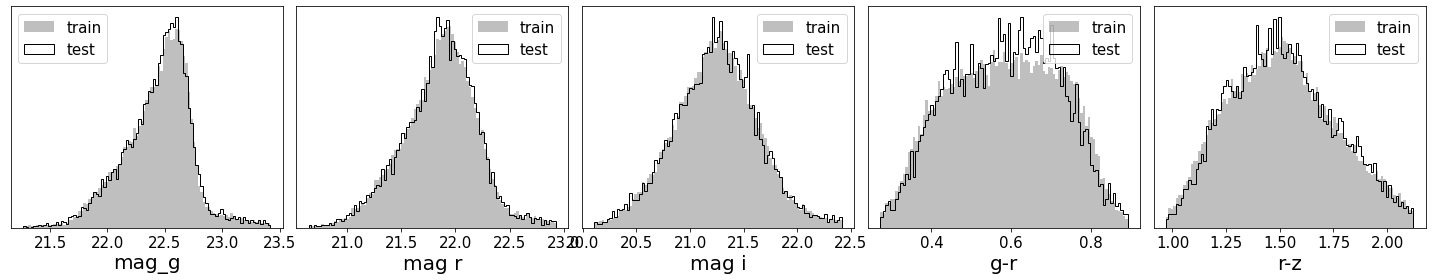

In [167]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
filename = 'figure/test.png'
doVisualization_1d( X_elg_true, X_sample_elg, 
                   labels = ['mag_g', 'mag r', 'mag i', 'g-r', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'test'], 
                   weight = [None,None], 
                   nbins=100, filename=filename)

Using central 98% to set range.


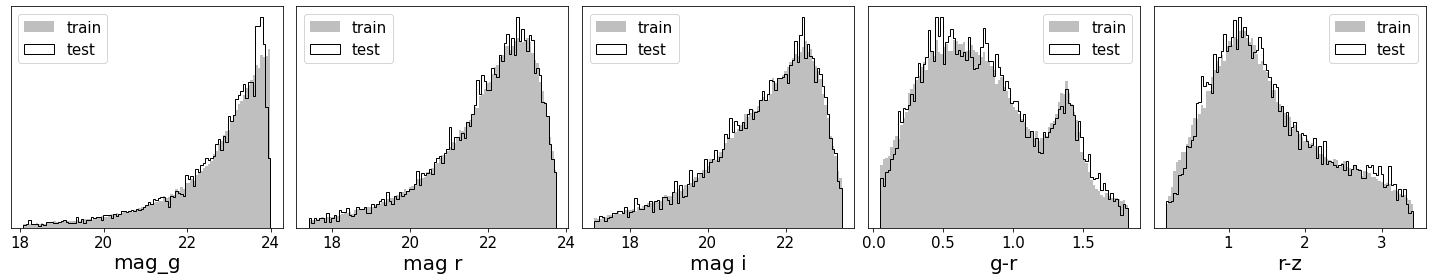

In [168]:
# Comparison. train vs. randoms for non-cmass
filename = 'figure/test.png'
doVisualization_1d( X_no_true, X_sample_no, 
                   labels = ['mag_g', 'mag r', 'mag i', 'g-r', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'test'], 
                   weight = [None,None], 
                   nbins=100, filename=filename)

In [214]:

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I', 'Z']

rand_ind = np.random.choice(gold_st82.size, size = 1000000)

# Assigning CMASS probabilities to Gold Y3 in Stripe 82.
# The probabilities are saved to 'CMASS_PROB' column 
gold_st82_test = assignELGProb(gold_st82[rand_ind], clf_elg, clf_no, 
                     cmass_fraction = elg_fraction, 
                     mag=mag, err=err, filter=filter )

calculate loglikelihood gaussian with multiprocessing module
['SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z']
multiprocessing 100 % 


In [215]:
# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_elg_true, Xcov = mixing_color_elg(clean_elg_data_des, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True)

['SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z']
['SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z']


In [216]:
# Generate Four columns of data : mag r, mag i, (g-r), (r-i)
X_delg_st82, Xcov = mixing_color_elg(gold_st82_test, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True )

['SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z']


In [148]:
# Comparison plot for the training sample (cmass) vs. dmass sample 
# DMASS sample should be weighted by 'CMASS_PROB' column when plotting
filename = 'figure/hist_color_elg.png'
weight_elg = gold_st82_test['ELG_PROB']
doVisualization_1d( X_elg_true, X_delg_st82, 
                   weight = [None, weight_elg],
                   labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   #labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'ELG st82'], 
                   nbins=100, filename=filename)

NameError: name 'gold_st82_test' is not defined

NameError: name 'gold_st82_test' is not defined

# Outside training region

Repeat for Y3 GOLD galaxies that are not in Stripe 82

Y3_GOLD None

--------------------------------
 calling catalog
--------------------------------
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000008.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000009.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000010.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000011.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000012.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000013.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000014.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000015.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000016.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000017.fits
reading 1/17 /n/des/lee.5922/data/gold_cat_Y3/SPT/701615bf64824498972491d545d1e4df/Y3_GOLD_2_0_SPT_ra10_

In [48]:
# callig saved pickles 

outdir = '../output/test_elg/fitting/'
os.makedirs(outdir, exist_ok=True)
elg_pickle = outdir+'gm_elg_Mgri_Cgr_rz.pkl'
no_pickle = outdir+'gm_no_Mgri_Cgr_rz.pkl'
f = open(outdir+'elgfrac', 'r')
elg_fraction = float(f.readline())

clf_elg = XD_fitting_X( None, None, pickleFileName = elg_pickle)               
clf_no = XD_fitting_X( None, None, pickleFileName = no_pickle)

In [57]:
outdir = '../output/test_elg/train_cat/'
train_filename = outdir+'train_sample_des.fits'
clean_elg_data_des = esutil.io.read(train_filename)

In [84]:
# Calling Y3 GOLD in a small square area 

# columns to call
columns = \
['RA', 'DEC', 'HPIX_4096', 
'COADD_OBJECT_ID', 
'EBV_SFD98',
'SOF_CM_MAG_CORRECTED_G',
'SOF_CM_MAG_CORRECTED_R',
'SOF_CM_MAG_CORRECTED_I',
'SOF_CM_MAG_CORRECTED_Z',
'SOF_CM_MAG_ERR_G',
'SOF_CM_MAG_ERR_R',
'SOF_CM_MAG_ERR_I',
'SOF_CM_MAG_ERR_Z']
# Y3 Gold (SPT) catalog directory
input_path = '/n/des/lee.5922/data/gold_cat_Y3/SPT/701615bf64824498972491d545d1e4df/'

# magnitudes and corresponding error columns that will be used
# to assign the DMASS (ELG) probability
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I', 'Z']

# directory to save
outdir = '../output/test_elg/test_cat/'
os.makedirs(outdir, exist_ok=True)

# Y3 GOLD catalog is too large to load all at once. 
# I split the catalog into 17 chuncks and load one by one 
# to assign the DMASS(ELG) probability 
for i in range(1,18):
    # catalog name
    input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_0000{:02.0f}.fits'.format(i)
    gold_spt_i = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
    gold_spt_i = gold_spt_i[priorCut_elg(gold_spt_i)]
    
    # assign probability
    gold_spt_prob_i = assignELGProb(gold_spt_i, clf_elg, clf_no, 
                     cmass_fraction = elg_fraction, 
                     mag=mag, err=err, filter=filter )
    
    # save fitsfile
    fitsname = 'DeBOSS_ELG_'+input_keyword
    print ('save to ', fitsname)
    esutil.io.write(outdir+fitsname, gold_spt_prob_i)
    
    # empty memory
    gold_spt_i, gold_spt_prob_i = None, None


Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_de

In [75]:
# calling the final catalog 
input_path = '../output/test_elg/test_cat/'
input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000'
gold_spt_prob = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=None)
#gold_spt_prob = gold_spt_prob[priorCut_elg(gold_spt_prob)]


Calling catalogs >>>
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000008.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000009.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000010.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000011.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000012.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000013.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000014.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000015.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000016.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_0000

In [76]:
X_delg, Xcov = mixing_color_elg(gold_spt_prob, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'],
                full = True  )
X_elg_true, X_elg_cov = mixing_color_elg(clean_elg_data_des, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True)

Using central 98% to set range.


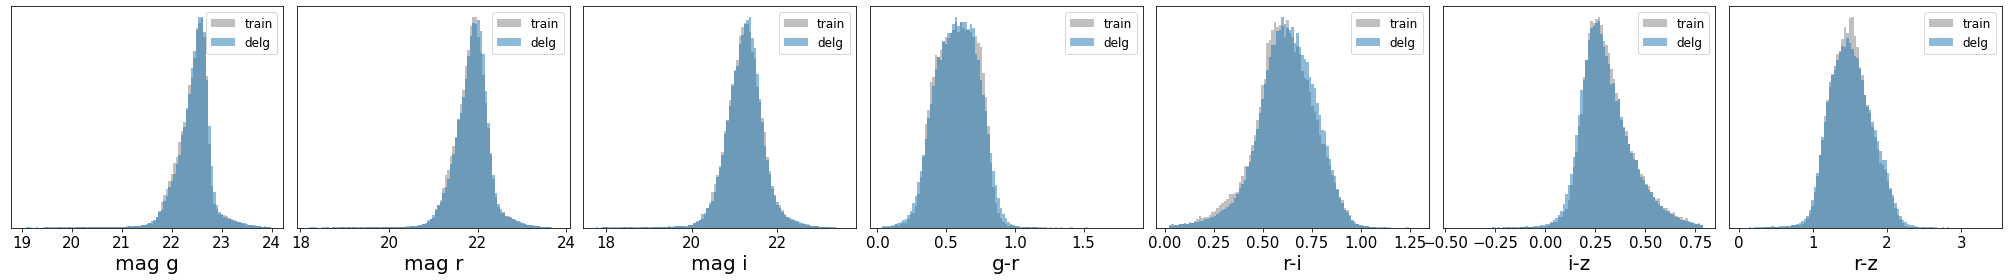

In [77]:
filename = 'figure/test.png'
weight_elg = gold_spt_prob['ELG_PROB']
doVisualization_1d(data=[X_elg_true, X_delg], 
                   weight = [None, weight_elg],
                   labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'delg'], 
                   nbins=100, 
                   filename=filename)

In [ ]:
#outdir = '../output/test_elg/test_cat/'
#esutil.io.write(outdir+'DeBOSS_ELG_ra10_20_decm40_m30.fits')

In [82]:
# compute number density
p01cut = gold_spt_prob['ELG_PROB'] > 0.01
ngal_elg = np.sum( gold_spt_prob['ELG_PROB'][p01cut])
ngal_total = gold_spt_prob.size
density = ngal_elg/ngal_total
print ('training sample number density: ', elg_fraction)
print ('ELG number density in GOLD Y3: ', density)

training sample number density:  0.0056635189
ELG number density in GOLD Y3:  0.006109054496397531


In [149]:
gold_spt_prob.size

2411672

2411672

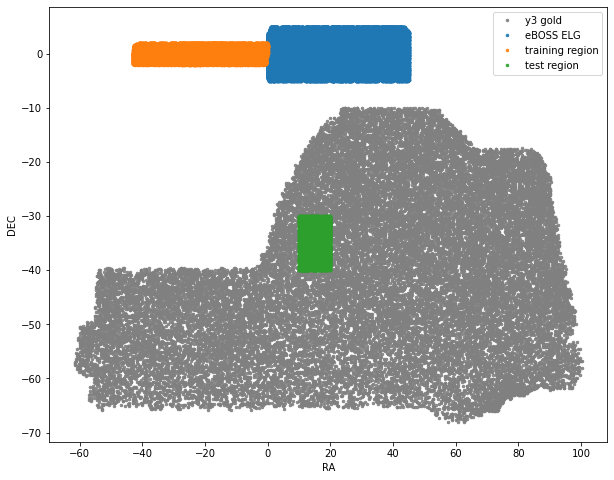

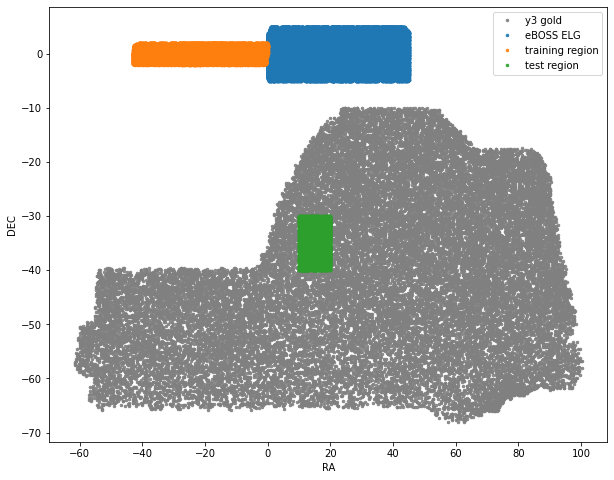

In [150]:
# Plotting footprint
#y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam10_000001.fits')
y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam100.fits')
randind=np.random.choice(y3goldsam.size, size=10000 )
randind_spt=np.random.choice(gold_spt_prob.size, size=10000 )
spatialcheck([y3goldsam, elg[elg['RA']<110], clean_elg_data_des,gold_spt_prob[randind_spt] ], 
             label = ['y3 gold', 'eBOSS ELG', 'training region', 'test region'], 
             convert = None, ratag='RA',dectag='DEC')